![giskard_logo.png](https://raw.githubusercontent.com/Giskard-AI/giskard/main/readme/Logo_full_darkgreen.png)

# About Giskard

Open-Source CI/CD platform for ML teams. Deliver ML products, better & faster. 

*   Collaborate faster with feedback from business stakeholders.
*   Deploy automated tests to eliminate regressions, errors & biases.

🏡 [Website](https://giskard.ai/)

📗 [Documentation](https://docs.giskard.ai/)

## Installing `giskard`

In [1]:
!pip install giskard

## Connect the external worker in daemon mode

In [2]:
!giskard worker start -d

2023-05-01 19:29:00,612 pid:44052 MainThread giskard.cli  INFO     Starting ML Worker client daemon
2023-05-01 19:29:00,613 pid:44052 MainThread giskard.cli  INFO     Python: /Users/pahu/opt/anaconda3/bin/python (3.9.12)
2023-05-01 19:29:00,613 pid:44052 MainThread giskard.cli  INFO     Giskard Home: /Users/pahu/giskard-home
2023-05-01 19:29:00,615 pid:44052 MainThread giskard.cli_utils INFO     Writing logs to /Users/pahu/giskard-home/run/ml-worker.log


# Start by creating an ML model 🚀🚀🚀

Let's create a credit scoring Model using the German Credit scoring dataset [(Link](https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification) to download the dataset)

In [4]:
import pandas as pd

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [5]:
# To download and read the credit scoring dataset
url = 'https://raw.githubusercontent.com/Giskard-AI/examples/main/datasets/credit_scoring_classification_model_dataset/german_credit_prepared.csv'
credit = pd.read_csv(url, sep=',',engine="python") #To download go to https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification

In [6]:
# Declare the type of each column in the dataset(example: category, numeric, text)
column_types = {'default':"category",
               'account_check_status':"category", 
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_employment_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_residence_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

In [7]:
# feature_types is used to declare the features the model is trained on
feature_types = {i:column_types[i] for i in column_types if i!='default'}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys() if feature_types[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types.keys() if feature_types[key]=="category"]
categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False)) ])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_to_scale),
      ('cat', categorical_transformer, columns_to_encode)
          ]
)

# Pipeline for the model Logistic Regression
clf_logistic_regression = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter =1000))])

# Split the data into train and test
Y=credit['default']
X= credit.drop(columns="default")
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20,random_state = 30, stratify = Y)

In [12]:
# Fit and score your model
clf_logistic_regression.fit(X_train, Y_train)

# The output is mean accuracy on the given test features and labels; which in my opinion is a wrong measure here
clf_logistic_regression.score(X_test, Y_test)

0.755

              precision    recall  f1-score   support

     Default       0.60      0.53      0.57        60
 Not default       0.81      0.85      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.75      0.76      0.75       200



/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


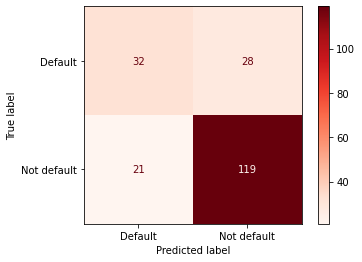

In [120]:
# comparing other Evaluation metrics as well
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, plot_confusion_matrix

Y_pred = clf_logistic_regression.predict(X_test)

# generate classification report
label_names = ['Default', 'Not default']

print(classification_report(Y_test, Y_pred, target_names=label_names))

# generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(clf_logistic_regression, X_test, Y_test, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# # changing cutoff for 
# Y_pred_class_cutoff = np.where(Y_prob >0.7, 1, 0)
# Y_pred_class_cutoff.sum()

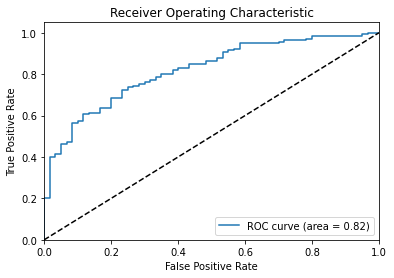

In [138]:
import numpy as np
import matplotlib.pyplot as plt

Y_prob = clf_logistic_regression.predict_proba(X_test)[:, 1]

# convert Y_test_aug and Y_prob to NumPy arrays if they are not already
Y_test_aug = np.array(Y_test)
Y_prob = np.array(Y_prob)


# convert Y_test_aug to binary encoding if it is not already
Y_test_aug = np.where(Y_test_aug == 'Not default', 1, 0)
# print(Y_test_aug.sum())

# calculate false positive rate (fpr) and true positive rate (tpr) for ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_aug, Y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Prepare data to upload on Giskard
train_data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test ], axis=1)

# Upload the model in Giskard 🚀🚀🚀

### Initiate a project

In [ ]:
from giskard import GiskardClient

url = "http://localhost:19000" #if Giskard is installed locally (for installation, see: https://docs.giskard.ai/start/guides/installation)
#url = "http://app.giskard.ai" # If you want to upload on giskard URL
token = "YOUR GENERATED TOKEN" #you can generate your API token in the Admin tab of the Giskard application (for installation, see: https://docs.giskard.ai/start/guides/installation)

client = GiskardClient(url, token)

# your_project = client.create_project("project_key", "PROJECT_NAME", "DESCRIPTION")
# Choose the arguments you want. But "project_key" should be unique and in lower case
credit_scoring = client.create_project("credit_scoring", "German Credit Scoring", "Project to predict if user will default")

# If you've already created a project with the key "credit-scoring" use
#credit_scoring = client.get_project("credit_scoring")


### Upload your model and a dataset (see [documentation](https://docs.giskard.ai/start/guides/upload-your-model))

In [ ]:
credit_scoring.upload_model_and_df(
    prediction_function=clf_logistic_regression.predict_proba, # Python function which takes pandas dataframe as input and returns probabilities for classification model OR returns predictions for regression model
    model_type='classification', # "classification" for classification model OR "regression" for regression model
    df=test_data, # the dataset you want to use to inspect your model
    column_types=column_types, # A dictionary with columns names of df as key and types(category, numeric, text) of columns as values
    target='default', # The column name in df corresponding to the actual target variable (ground truth).
    feature_names=list(feature_types.keys()), # List of the feature names of prediction_function
    classification_labels=clf_logistic_regression.classes_ ,  # List of the classification labels of your prediction
    model_name='logistic_regression_v1', # Name of the model
    dataset_name='test_data' # Name of the dataset
)

### 🌟 If you want to upload a dataset without a model






For example, let's upload the train set in Giskard, this is key to create drift tests in Giskard.


In [ ]:
credit_scoring.upload_df(
    df=train_data, # The dataset you want to upload
    column_types=column_types, # All the column types of df
    target="default", # Do not pass this parameter if dataset doesn't contain target column
    name="train_data" # Name of the dataset
)

You can also upload new production data to use it as a validation set for your existing model. In that case, you might not have the ground truth target variable

In [ ]:
production_data = credit.drop(columns="default")

In [ ]:
credit_scoring.upload_df(
    df=production_data, # The dataset you want to upload
    column_types=feature_types, # All the column types without the target
    name="production_data"# Name of the dataset
)

### 🌟 If you just want to upload a model without a dataframe 

This happens for instance when you built a new version of the model and you want to inspect it using a validation dataframe that is already in Giskard

For example, let's create a second version of the model using random forest

In [ ]:
clf_random_forest = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=10,random_state=0))])

clf_random_forest.fit(X_train, Y_train)
clf_random_forest.score(X_test, Y_test)

In [ ]:
credit_scoring.upload_model(
    prediction_function=clf_random_forest.predict_proba, # Python function which takes pandas dataframe as input and returns probabilities for classification model OR returns predictions for regression model
    model_type='classification', # "classification" for classification model OR "regression" for regression model
    feature_names=list(feature_types.keys()), # List of the feature names of prediction_function
    name='random_forest', # Name of the model
    validate_df=train_data, # Optional. Validation df is not uploaded in the app, it's only used to check whether the model has the good format
    target="default", # Optional. target should be a column of validate_df. Pass this parameter only if validate_df is being passed
    classification_labels=["Default","Not default"] # List of the classification labels of your prediction

)

### Happy Exploration ! 🧑‍🚀